Many thanks to the 2016 Decemberist class and the many insightful comments.
Particularly like to thank
https://github.com/carlosgalvezp/Udacity-Self-Driving-Car-Nanodegree/tree/master/term1/projects/p3-behavioral-cloning

Size of data set 8036


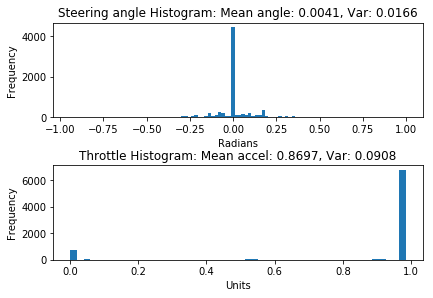

In [10]:
#Data exploration
import random
import cv2
import numpy as np
import pandas as pd
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
import os
import cv2
import math
import numpy as np
import pandas as pd
import csv
import time
import argparse
import json

#Load data
d_f = pd.read_csv('data/driving_log.csv')

def hist_plot(d_f):
    print("Size of data set", len(d_f))
    #Get steering and accelaration details
    steer_rad= d_f['steering'].tolist()
    throttle = d_f['throttle'].tolist()
    #Mean
    ave_steer = np.mean(steer_rad)
    var_steer = np.var(steer_rad)
    #Variance
    ave_throt = np.mean(throttle)
    var_throt =np.var(throttle)

    #Plot histograms
    f, axarr = plt.subplots(2, 1)
    axarr[0].hist(steer_rad, bins=100),axarr[0].set_title("Steering angle Histogram: Mean angle: {0:.4f}, Var: {1:.4f}".format(ave_steer, var_steer)),axarr[0].set_xlabel("Radians"), axarr[0].set_ylabel("Frequency")
    axarr[1].hist(throttle, bins=50),axarr[1].set_title("Throttle Histogram: Mean accel: {0:.4f}, Var: {1:.4f}".format(ave_throt, var_throt)),axarr[1].set_xlabel("Units"), axarr[1].set_ylabel("Frequency")
    plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)
    plt.show()
    %matplotlib inline 
#Display histograms
hist_plot(d_f)

In [11]:
#Count number of 0.0 steering angles
acc_zero = d_f['steering']
non_zero  = np.count_nonzero(acc_zero)
total_zero = len(acc_zero) - non_zero
print("Total number of zero acceleration entries: {0}, total number of other entries: {1}".format(total_zero, non_zero))

Total number of zero acceleration entries: 4361, total number of other entries: 3675


Size of data set 4181


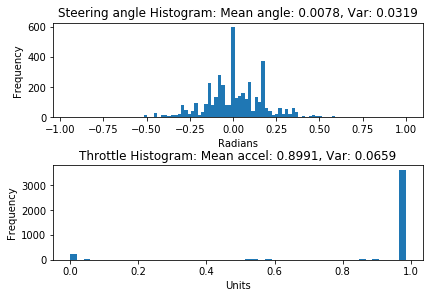

In [12]:
#Drop 90% of zero angle data
drop = int(0.2*total_zero)

#Get non-zero and zero entries
df_n = d_f[d_f.steering != 0]
df_z = d_f[d_f.steering == 0]
df_z = df_z.ix[:drop]

#Augment new entries with non-zero angle entries
new_dataset = pd.concat([df_z, df_n])
hist_plot(new_dataset)
#new_dataset = d_f

Size of data set 4181


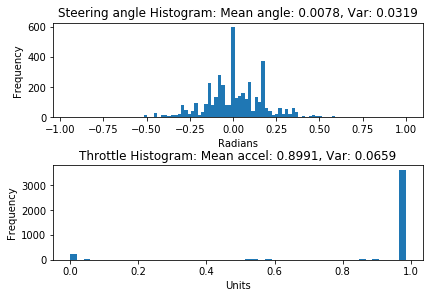

Size of data set 4181


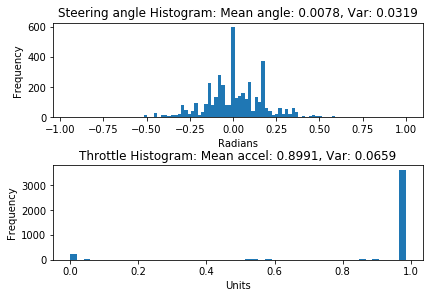

In [13]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split
#train, test = train_test_split(new_dataset, test_size = 0.10)
train = new_dataset
test = new_dataset
#Display new data set stats
hist_plot(train)
hist_plot(test)

In [14]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation, ELU
from keras.optimizers import Adam
from keras.callbacks import Callback
import matplotlib.image as mpimg
#Load data
d_f = pd.read_csv('data/driving_log.csv')
ANGLE_OFFSET = 0.25

# Angle offsets applied to center, left and right image
ANGLE_OFFSETS = [0.0, ANGLE_OFFSET, -ANGLE_OFFSET]

# Batch size
BATCH_SIZE = 64

In [15]:
import cv2
import numpy as np
def preprocess_input(x):
    FINAL_IMG_SHAPE = (66, 200, 3)

    height = x.shape[0]
    width = x.shape[1]

    factor = float(FINAL_IMG_SHAPE[1]) / float(width)

    resized_size = (int(width*factor), int(height*factor))
    x = cv2.resize(x, resized_size)
    crop_height = resized_size[1] - FINAL_IMG_SHAPE[0]

    return x[crop_height:, :, :]

In [16]:
def random_horizontal_flip(x, y):
    flip = np.random.randint(2)

    if flip:
        x = cv2.flip(x, 1)
        y = -y

    return x, y

def random_translation(img, steering):
    # Maximum shift of the image, in pixels
    trans_range = 50  # Pixels

    # Compute translation and corresponding steering angle
    tr_x = np.random.uniform(-trans_range, trans_range)
    steering = steering + (tr_x / trans_range) * ANGLE_OFFSET

    # Warp image using the computed translation
    rows = img.shape[0]
    cols = img.shape[1]

    M = np.float32([[1,0,tr_x],[0,1,0]])
    img = cv2.warpAffine(img,M,(cols,rows))

    return img, steering

def data_augmentation(x, y):
    # Random horizontal shift
    x, y = random_translation(x, y)

    # Random flip
    x, y = random_horizontal_flip(x, y)

    return x, y

In [17]:
def train_generator(X,y, batch_size):
    """ Provides a batch of images from a log file. The main advantage
        of using a generator is that we do not need to read the whole log file,
        only one batch at a time, so it will fit in RAM.
        This function also generates extended data on the fly. """
    # Supply training images indefinitely
    while 1:
        # Declare output data
        x_out = []
        y_out = []
        
        # Fill batch
        for i in range(0, batch_size):
            # Get random index to an element in the dataset.
            idx = np.random.randint(len(y))

            # Randomly select which of the 3 images (center, left, right) to use
            idx_img = np.random.randint(len(ANGLE_OFFSETS))

            # Read image and steering angle (with added offset)
            x_i = mpimg.imread(X[idx][idx_img].strip())
            y_i = y[idx] + ANGLE_OFFSETS[idx_img]

            # Preprocess image
            x_i = preprocess_input(x_i)

            # Augment data
            x_i, y_i = data_augmentation(x_i, y_i)

            # Add to batch
            x_out.append(x_i)
            y_out.append(y_i)

        yield (np.array(x_out), np.array(y_out))


def val_generator(X, y):
    """ Provides images for validation. This generator is different
        from the previous one in that it does **not** perform data augmentation:
        it just reads images from disk, preprocess them and yields them """
    # Validation generator
    while 1:
        for i in range(len(y)):
            # Read image and steering angle
            x_out = mpimg.imread(X[i][0].strip())
            y_out = np.array([[y[i]]])

            # Preprocess image
            x_out = preprocess_input(x_out)
            x_out = x_out[None, :, :, :]

            # Return the data
            yield x_out, y_out


def make_multiple(x, number):
    """ Increases x to be the smallest multiple of number """
    return int(math.ceil(float(x) / float(number)) * number)


def normalize(X):
    """ Normalizes the input between -0.5 and 0.5 """
    return X / 255. - 0.5

In [18]:
""" Defines the network architecture, following Nvidia's example on:
        http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf """

""" Defines the network architecture, following Nvidia's example on:
        http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf """

# Parameters
FINAL_IMG_SHAPE = (66, 200, 3)

input_shape = FINAL_IMG_SHAPE

weight_init='glorot_uniform'
padding = 'valid'
dropout_prob = 0.25

# Define model
model = Sequential()

model.add(Lambda(normalize, input_shape=input_shape, output_shape=input_shape))

model.add(Convolution2D(24, 5, 5,
                            border_mode=padding,
                            init = weight_init, subsample = (2, 2)))
model.add(ELU())
model.add(Convolution2D(36, 5, 5,
                            border_mode=padding,
                            init = weight_init, subsample = (2, 2)))
model.add(ELU())
model.add(Convolution2D(48, 5, 5,
                            border_mode=padding,
                            init = weight_init, subsample = (2, 2)))
model.add(ELU())
model.add(Convolution2D(64, 3, 3,
                            border_mode=padding,
                            init = weight_init, subsample = (1, 1)))
model.add(ELU())
model.add(Convolution2D(64, 3, 3,
                            border_mode=padding,
                            init = weight_init, subsample = (1, 1)))

model.add(Flatten())
model.add(Dropout(dropout_prob))
model.add(ELU())

model.add(Dense(100, init = weight_init))
model.add(Dropout(dropout_prob))
model.add(ELU())

model.add(Dense(50, init = weight_init))
model.add(Dropout(dropout_prob))
model.add(ELU())

model.add(Dense(10, init = weight_init))
model.add(Dropout(dropout_prob))
model.add(ELU())

model.add(Dense(1, init = weight_init, name = 'output'))

model.summary()

# Compile it
model.compile(loss = 'mse', optimizer = Adam(lr = 0.001))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 66, 200, 3)    0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_9 (ELU)                      (None, 31, 98, 24)    0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 14, 47, 36)    21636       elu_9[0][0]                      
___________________________________________________________________________________________

In [19]:
def get_training_data(data):
    """ Reads the CSV file and splits it into training and validation sets """
    # Read CSV file with pandas
   
    # Get image paths and steering angles
    X = np.column_stack((np.copy(data['center']), np.copy(data['left']), np.copy(data['right'])))
    y = np.copy(data['steering'])

    return X, y

In [20]:
batch_size = 64
X_train, y_train =  get_training_data(train)
X_test, y_test =  get_training_data(train)

In [23]:
n_train_samples = 5 * make_multiple(len(y_train), batch_size)
n_val_samples = len(y_test)
n_epochs = 5
gen_train = train_generator(X_train, y_train, batch_size)
gen_val = val_generator(X_test, y_test)


model.fit_generator(generator = gen_train,
                        samples_per_epoch = n_train_samples,
                        validation_data = gen_val,
                        nb_val_samples = n_val_samples,
                        nb_epoch = n_epochs,
                       
                        verbose = 1)

Epoch 1/5
21120/21120 [==============================] - 55s - loss: 0.0404 - val_loss: 0.0278

In [24]:
#Save final model as specified in Udacity ruberic
# serialize model to JSON
model_json = model.to_json()
with open("../../model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save('../../model.h5') 
print("Saved model to disk")

Saved model to disk
